In [10]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from datetime import datetime
import wandb
from tqdm import tqdm


def binary_mask(img_path : str)-> np.ndarray:

    try:
        img = Image.open(img_path).convert('RGB')
        img_arry = np.array(img)
    except FileNotFoundError:
        print("Error Not found")
        return None

    
    height ,width,_ = img_arry.shape

    mask = np.zeros((height,width), dtype = np.int64)

    purple_color = np.array([138,43,226])

    belgium_pixels = np.all(img_arry == purple_color , axis=-1)

    mask[belgium_pixels] = 1

    return mask

class BorderDataset:

    def __init__(self , image_path : str):
        
        self.mask = binary_mask(img_path=image_path)
        if self.mask is None:
            raise RuntimeError("mask Not created")
        
        self.height , self.width  = self.mask.shape

        self.pixel_data = []
        for y in range (self.height):
            for x in range(self.width):
                label = self.mask[y,x]
                self.pixel_data.append(((x,y), label))


    def __len__(self) -> int:

        return len (self.pixel_data)
    

    def __getitem__(self , idx : int):

        (x_cord , y_cord) , label = self.pixel_data[idx]

        x_norm = x_cord / (self.width-1)
        y_norm = y_cord / (self.height - 1)

        coordinates = np.array([x_norm , y_norm] , dtype= np.float32)

        label = np.array(label , dtype=np.int64)

        return coordinates , label
    

class CustomDataloader:

    def __init__(self ,dataset , batchsize , shuffel  = True):

        self.dataset = dataset
        self.batchsize = batchsize
        self.shuffel = shuffel
        self.indices = list(range(len(dataset)))

    def __iter__(self):

        if self.shuffel:
            np.random.shuffle(self.indices)

        for i in range (0 , len(self.indices) ,self.batchsize):
            batch_indices = self.indices[i:i + self.batchsize]
            x_batch , y_batch = [],[]
            for idx in batch_indices:
                x , y = self.dataset[idx]
                x_batch.append(x)
                y_batch.append(y)
            yield np.array(x_batch) , np.array(y_batch)

    def __len__(self):

        return (len(self.dataset) + self.batchsize-1) // self.batchsize
    

class Linear:

    def __init__(self , input_width : int  , output_width : int , activation_function):

        self.input_width = input_width
        self.output_width  = output_width
        self.activation = activation_function

        self.W = np.random.randn(self.output_width , self.input_width) * np.sqrt(2. / self.input_width)
        self.b = np.zeros((self.output_width,1))

        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

        self.A_prev = None
        self.Z = None


    def forward(self , A_prev : np.ndarray) -> np.ndarray:

        self.A_prev = A_prev
        self.Z = np.dot(self.W , self.A_prev) + self.b
        A = self.activation.forward(self.Z)
        return A
    
    def backward(self , dA : np.ndarray) -> np.ndarray:

        m = self.A_prev.shape[1]

        dZ = dA * self.activation.backward(self.Z)

        self.dW = (1/m) * np.dot(dZ , self.A_prev.T)
        self.db = (1/m) * np.sum(dZ , axis = 1 ,keepdims=True)

        dA_prev = np.dot(self.W.T , dZ)
        return dA_prev



class ReLU:

    def forward(self ,Z: np.ndarray) -> np.ndarray:

        return np.maximum(0,Z)
    
    def backward(self, Z: np.ndarray) -> np.ndarray:

        derivative = (Z > 0).astype(float)
        return derivative
    

class Tanh:

    def forward(self ,Z: np.ndarray) -> np.ndarray:

        return np.tanh(Z)
    
    def backward(self, Z: np.ndarray) -> np.ndarray:

        return 1-np.tanh(Z)**2
    

class Sigmoid:

    def forward(self ,Z: np.ndarray) -> np.ndarray:

       Z_clipped = np.clip(Z ,-500 , 500)
       return 1/(1 + np.exp(-Z_clipped))

    
    def backward(self, Z: np.ndarray) -> np.ndarray:

        s = self.forward(Z)
        return s * (1-s)
    


class Identity:

    def forward(self ,Z: np.ndarray) -> np.ndarray:

        return Z
    
    def backward(self, Z: np.ndarray) -> np.ndarray:

        return np.ones_like(Z)
    

class Model:

    def __init__(self , layers : list , loss_function_type : str = "MSE" , learning_rate : float = 0.01):

        self.layers = layers
        self.learning_rate = learning_rate

        if loss_function_type.upper() == "MSE":
            self.loss_func = self.mean_squared_error
            self.loss_derivative = self.mean_squared_error_derivative
        elif loss_function_type.upper() == "BCE":
            self.loss_func = self.binary_cross_entropy
            self.loss_derivative = self.binary_cross_entropy_derivative
        else:
            raise ValueError("Unsupported loss function")
        

    def mean_squared_error(self , y_pred , y_train):
        return np.mean((y_pred - y_train) ** 2)
    
    def mean_squared_error_derivative(self, y_pred , y_true):
        return 2* (y_pred - y_true) / y_true.size
    
    def binary_cross_entropy(self , y_pred , y_true):

        epsilon = 1e-15
        y_pred = np.clip(y_pred , epsilon , 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1- y_true) * np.log(1- y_pred) )
    
    def binary_cross_entropy_derivative(self , y_pred , y_true):

        epsilon = 1e-15
        y_pred = np.clip(y_pred , epsilon , 1-epsilon)
        return -(y_true / y_pred - (1 - y_true) / (1 - y_pred))
    

    def forward(self , X : np.ndarray) -> np.ndarray:

        A = X
        for layer in self.layers:
            A = layer.forward(A)
        return A
    
    def backward(self , dAL : np.ndarray):

        dA = dAL
        for layer in reversed(self.layers):
            dA = layer.backward(dA)


    def train(self , x : np.ndarray , y : np.ndarray) -> tuple[float ,float]:

        y_pred = self.forward(x)
        loss = self.loss_func(y_pred , y)
        dAL = self.loss_derivative(y_pred , y)
        self.backward(dAL)

        predictions = (y_pred > 0.5).astype(int)
        accuracy = np.mean(predictions == y)
        return loss , accuracy
    
    def zero_grad(self):

        for layer in self.layers:
            layer.dW.fill(0)
            layer.db.fill(0)

    
    def update(self):

        for layer in self.layers:
            layer.W -= self.learning_rate * layer.dW
            layer.b -= self.learning_rate * layer.db

        self.zero_grad()

    def predict(self , x: np.ndarray) -> np.array:

        return self.forward(x)
    

    def save_to(self , path : str):

        params = {}

        for i , layer in enumerate(self.layers):

            params[f'W{i}'] = layer.W
            params[f'b{i}'] = layer.b
        np.savez(path , **params)
        print(f"Model saved to {path}")

    
    def load_fram(self , path:str):

        if not os.path.exists(path):
            raise FileNotFoundError("No file found at path")
        
        loaded_params = np.load(path)

        if len(loaded_params.files) != len(self.layers) * 2:
            raise ValueError("Number of layers does not match")
        

        for i , layer in enumerate(self.layers):
            W_key , b_key = f'W{i}' , f'b{i}'

            if W_key not in loaded_params or b_key not in loaded_params:
                raise ValueError(f"Parameters for layer {i} not found in file")
            
            if layer.W.shape != loaded_params[W_key].shape:
                raise ValueError(f"Shape mismatch for W{i}:Model has {layer.W.shape}, file has {loaded_params[W_key].shape} ")
            if layer.b.shape != loaded_params[b_key].shape:
                raise ValueError(f"Shape mismatch for b{i}: Model has {layer.b.shape}, file has {loaded_params[b_key].shape}")
            
            layer.W = loaded_params[W_key]
            layer.b = loaded_params[b_key]

        print(f" Model loaded successfully from{path}")


def train_model( model : Model , dataset : BorderDataset , epochs : int , batch_size : int , grad_accumulation_steps : int, early_stopping_patience: int  = 10 , 
                early_stopping_threshold: float = 0.01):

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_folder = os.path.join("runs" , timestamp)
    os.makedirs(run_folder ,exist_ok=True)

    config = {
        "learning_rate" : model.learning_rate,
        "epochs": epochs,
        "batch_size": batch_size,
        "grad_accumulation_steps": grad_accumulation_steps,
        "architecture": [f"Linear ({l.input_width} ,{l.output_width})" for l in model.layers],"optimizer" : "SGD",
        "early_stopping patience": early_stopping_patience , "early_stopping_threshold" : early_stopping_threshold
    }
    wandb.init(project="border-mlp--from-scratch" , config=config , name = f"run-{timestamp}")

    dataloader = CustomDataloader(dataset , batchsize=batch_size , shuffel= True)

    losses = []
    samples_seen_log = []
    samples_seen_total = 0
    epoch_avg_losses = []

    model.zero_grad()

    for epoch in range(epochs):
        epoch_loss_sum , epoch_batches = 0,0
        pbar = tqdm(dataloader , desc = f'Epoch {epoch+1}/{epochs}')
        for i , (x_batch , y_batch) in enumerate(pbar):
            x_batch = x_batch.T
            y_batch = y_batch.reshape(1,-1)

            loss , acc = model.train(x_batch , y_batch)
            epoch_loss_sum += loss
            epoch_batches += 1

            if (i+1) % grad_accumulation_steps == 0:
                model.update()

                avg_loss = loss
                avg_acc = acc
                samples_seen_total += (batch_size * grad_accumulation_steps)

                losses.append(avg_loss)
                samples_seen_log.append(samples_seen_total)

                wandb.log({"loss": avg_loss , "accuracy" : avg_acc , "samples_seen":samples_seen_total})
                pbar.set_postfix({"loss":f"{avg_loss : 4f}" , "acc": f"{avg_acc:.2f}"})

        avg_loss_for_epoch = epoch_loss_sum / epoch_batches
        epoch_avg_losses.append(avg_loss_for_epoch)
        wandb.log({"epoch" : epoch+1 , "epoch_avg_loss": avg_loss_for_epoch})

        if len(epoch_avg_losses) > early_stopping_patience:
            current_loss = epoch_avg_losses[-1]
            past_loss = epoch_avg_losses[-1 - early_stopping_patience]
            if current_loss >= (1.0 - early_stopping_threshold) * past_loss:
                print(f"Early Stopping Triggered at epoch {epoch+1}")
                print(f"Current Loss ({ current_loss : .6f}) did nto improve by at least{early_stopping_threshold*100} % over the loss from {early_stopping_patience} epoch ago ({past_loss: .6f}).")
                break


    final_model_path = os.path.join(run_folder , "final_model.npz")
    model.save_to(final_model_path)
    model_artifact = wandb.Artifact(
        "final-model", type="model",
        description="The final trained model parameters after all epochs.",
        metadata=config)
    model_artifact.add_file(final_model_path)
    wandb.log_artifact(model_artifact)


    plt.figure(figsize=(10,5))
    plt.plot(samples_seen_log,losses)
    plt.xlabel("Number of Samples Seen")
    plt.ylabel("Loss")
    plt.title("Training Loss vs Samples Seen")
    plt.grid(True)
    plot_path = os.path.join(run_folder , "loss_plot.png")
    plt.savefig(plot_path)
    plt.show()

    wandb.finish()
    print("Training Complete")



def run_xor_test():

    X_train = np.array([[0,0,1,1] , [0,1,0,1]] , dtype= np.float32)
    Y_train = np.array([[0,1,1,0]], dtype = np.float32)

    architectures = {
        "2-layer ReLU":(lambda :[
            Linear(2,4, ReLU()),
            Linear(4,1, Sigmoid())
        ]),
        "2-layer Tanh":(lambda:[
            Linear(2,4, Tanh()),
            Linear(4,1, Sigmoid())
        ]),
        "3-layer Wide ReLU":(lambda:[
            Linear(2,8, ReLU()),
            Linear(8,4, ReLU()),
            Linear(4,1, Sigmoid())
        ])
    }

    for name, arch__builder in architectures.items():

        print(f" \nTesting Architecture: '{name}")

        layers = arch__builder()

        model = Model( layers , loss_function_type="BCE", learning_rate=0.1)

        epochs = 10000

        for epoch in range(epochs):
            loss , acc = model.train(X_train,Y_train)
            model.update()
            if (epoch+1) % 2000 == 0:
                print(f"Epoch {epoch+1} : Loss = {loss: .4f} , Accuracy = {acc*100: .2f}%")

        preds = (model.predict(X_train) > 0.5).astype(int)
        print("Final Prediction")
        for i in range(4):
            print(f" Input {X_train[: , i]} -> Predicted: {preds[0,i]} , Actual : {int(Y_train[0,i])}")
        print("_"*50)


    


         


# Ques 1 Belgium Netherlands Border

### 1.1 Image Processing and Dataset Creation 

#### Binary Mask

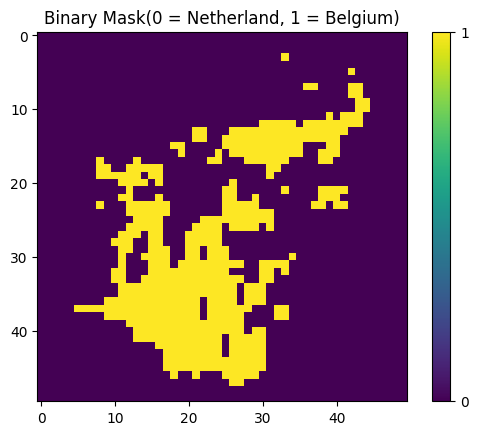

In [2]:
Imagepath = "border.png"

Binary_mask = binary_mask(img_path= Imagepath)

plt.imshow(Binary_mask , cmap="viridis")
plt.title(('Binary Mask(0 = Netherland, 1 = Belgium)'))
plt.colorbar(ticks = [0,1])
plt.show()

#### Border Dataset

In [3]:
Imagepath = "border.png"

border_dataset = BorderDataset(image_path= Imagepath)
data_loder = CustomDataloader(border_dataset , batchsize=10 ,shuffel=True )

print(f" Total Samples : {len(border_dataset)}")

cords_batch , labels_batch = next(iter(data_loder))
print(f"Coordinates Tensor Shape:{cords_batch.shape}")
print(f"labels Tensor Shape: {labels_batch.shape}")
print(f"Sample Coordinates(Normalized):\n" , cords_batch)
print(f"Corresponding Labels: \n" , labels_batch)
            


 Total Samples : 2500
Coordinates Tensor Shape:(10, 2)
labels Tensor Shape: (10,)
Sample Coordinates(Normalized):
 [[0.24489796 0.71428573]
 [0.7346939  0.67346936]
 [0.6530612  0.6938776 ]
 [0.06122449 0.67346936]
 [0.8367347  0.71428573]
 [0.         0.9591837 ]
 [0.6530612  0.93877554]
 [0.8979592  0.3877551 ]
 [0.20408164 0.46938777]
 [0.67346936 0.5510204 ]]
Corresponding Labels: 
 [1 0 0 0 0 0 0 0 0 0]


### 1.2 Neural Network Implementation from Scratch

#### Plot of the training loss versus the number of samples seen for "BCE

wandb: Currently logged in as: shriansh-sahu (shriansh-sahu-iiit-hyderabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 32/3000: 100%|███████| 10/10 [00:00<00:00, 179.66it/s, loss=0.565816, acc=0.77]


Early Stopping Triggered at epoch 32
Current Loss ( 0.536613) did nto improve by at least1.0 % over the loss from 10 epoch ago ( 0.541804).
Model saved to runs\20251012_194659\final_model.npz


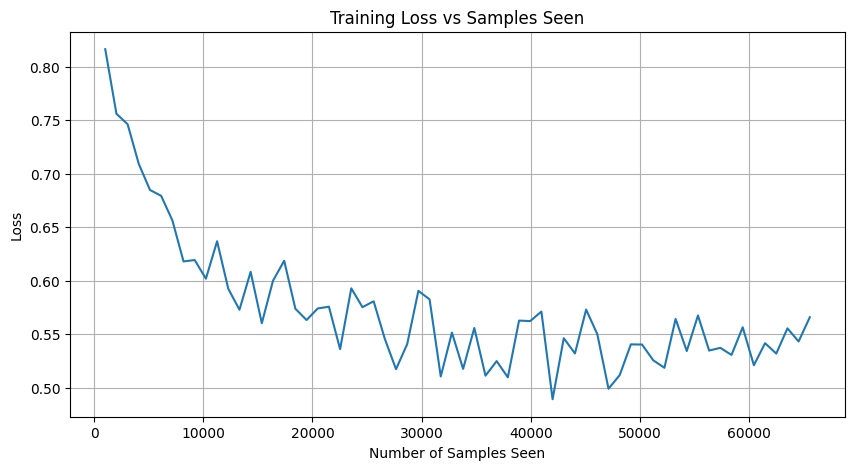

accuracy,▁▂▂▃▄▅▆▆███▇▇███▇▇██▇█▇█▇█▇█▇█▇█▇▇▇█▇▇█▇
epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
epoch_avg_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▇▆▅▅▄▃▃▃▃▂▃▃▃▂▃▂▂▂▁▃▃▁▂▂▁▁▂▂▂▂▃▂▂▂▂▂▂▂▃
samples_seen,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
accuracy,0.76562
epoch,32
epoch_avg_loss,0.53661
loss,0.56582
samples_seen,65536


Training Complete


In [13]:
IMAGE_FILE = 'border.png'
Epochs = 3000
Learning_Rate = 0.005
Batch_size = 256
Grad_Accumulation_Steps = 4

dataset = BorderDataset(image_path=IMAGE_FILE)


layers = [
    Linear(input_width=2,output_width=128,activation_function= Tanh()),
    Linear(input_width=128, output_width=128 , activation_function= Tanh()),
    Linear(input_width= 128 , output_width= 1 , activation_function= Sigmoid())
]

mlp_model = Model(
    layers= layers,
    loss_function_type= "BCE",
    learning_rate=Learning_Rate
)

train_model(
    model = mlp_model,
    dataset = dataset,
    epochs = Epochs,
    batch_size=Batch_size,
    grad_accumulation_steps=Grad_Accumulation_Steps,
    early_stopping_patience=10,
    early_stopping_threshold=0.01
)


#### Plot of the training loss versus the number of samples seen for "MSE"

Epoch 11/3000: 100%|███████| 10/10 [00:00<00:00, 198.09it/s, loss=0.241835, acc=0.65]


Early Stopping Triggered at epoch 11
Current Loss ( 0.242279) did nto improve by at least1.0 % over the loss from 10 epoch ago ( 0.242628).
Model saved to runs\20251012_194808\final_model.npz


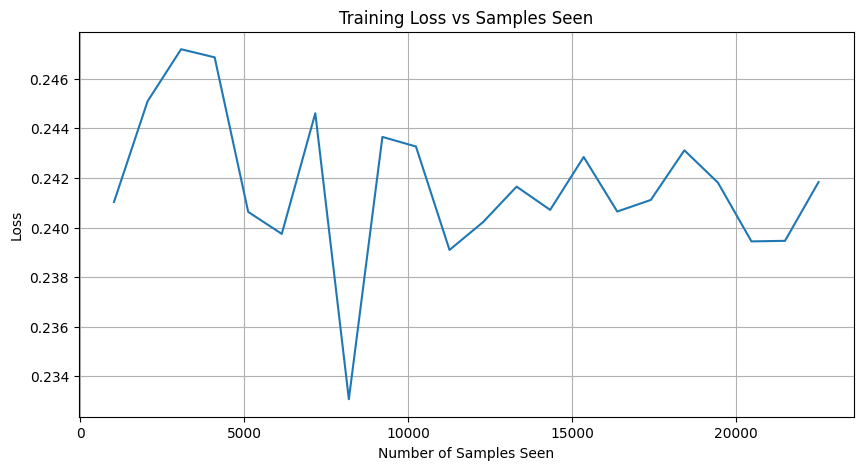

accuracy,▅▂▂▁▄▅▂█▃▃▅▅▄▅▄▄▄▃▃▅▅▄
epoch,▁▂▂▃▄▅▅▆▇▇█
epoch_avg_loss,█▆█▇▆▅▃▄▃▁▂
loss,▅▇██▅▄▇▁▆▆▄▅▅▅▆▅▅▆▅▄▄▅
samples_seen,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
accuracy,0.65234
epoch,11
epoch_avg_loss,0.24228
loss,0.24183
samples_seen,22528


Training Complete


In [14]:
IMAGE_FILE = 'border.png'
Epochs = 3000
Learning_Rate = 0.005
Batch_size = 256
Grad_Accumulation_Steps = 4

dataset = BorderDataset(image_path=IMAGE_FILE)


layers = [
    Linear(input_width=2,output_width=128,activation_function= Tanh()),
    Linear(input_width=128, output_width=128 , activation_function= Tanh()),
    Linear(input_width= 128 , output_width= 1 , activation_function= Sigmoid())
]

mlp_model = Model(
    layers= layers,
    loss_function_type= "MSE",
    learning_rate=Learning_Rate
)

train_model(
    model = mlp_model,
    dataset = dataset,
    epochs = Epochs,
    batch_size=Batch_size,
    grad_accumulation_steps=Grad_Accumulation_Steps,
    early_stopping_patience=10,
    early_stopping_threshold=0.01
)


In [12]:
run_xor_test()

 
Testing Architecture: '2-layer ReLU
Epoch 2000 : Loss =  0.0133 , Accuracy =  100.00%
Epoch 4000 : Loss =  0.0049 , Accuracy =  100.00%
Epoch 6000 : Loss =  0.0029 , Accuracy =  100.00%
Epoch 8000 : Loss =  0.0021 , Accuracy =  100.00%
Epoch 10000 : Loss =  0.0016 , Accuracy =  100.00%
Final Prediction
 Input [0. 0.] -> Predicted: 0 , Actual : 0
 Input [0. 1.] -> Predicted: 1 , Actual : 1
 Input [1. 0.] -> Predicted: 1 , Actual : 1
 Input [1. 1.] -> Predicted: 0 , Actual : 0
__________________________________________________
 
Testing Architecture: '2-layer Tanh
Epoch 2000 : Loss =  0.0143 , Accuracy =  100.00%
Epoch 4000 : Loss =  0.0067 , Accuracy =  100.00%
Epoch 6000 : Loss =  0.0043 , Accuracy =  100.00%
Epoch 8000 : Loss =  0.0032 , Accuracy =  100.00%
Epoch 10000 : Loss =  0.0025 , Accuracy =  100.00%
Final Prediction
 Input [0. 0.] -> Predicted: 0 , Actual : 0
 Input [0. 1.] -> Predicted: 1 , Actual : 1
 Input [1. 0.] -> Predicted: 1 , Actual : 1
 Input [1. 1.] -> Predicted: 